In [15]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
def leapfrog(theta, A, r, eps):
    #gradients are specific to this example
    gradients = A.dot(theta)
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = A.dot(theta_upd)
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [18]:
def log_joint(theta, A):
    #seems like this can be up to a normalizing constant so that's what i did, but otherwise that could be the issue
    return -1/2 * theta.T.dot(A).dot(theta)


In [19]:
def BuildTree(theta,A, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(theta,A,r,v*eps)
        if(u <= np.exp(log_joint(theta_prime,A)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(log_joint(theta_prime,A)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(theta,A,r,u,v,j-1,eps)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep = BuildTree(theta_minus,A,r_minus,u,v,j-1,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep = BuildTree(theta_plus,A,r_plus,u,v,j-1,eps) 
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime

In [20]:
def NUTS_Mvt(theta0,A,eps,M):
    no_par = theta0.shape[0]
    theta_m = np.zeros((M,no_par))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=no_par)
        u = np.random.uniform(low=0,high=np.exp(log_joint(theta_m[m-1,:],A)-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree(theta_minus,A,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(theta_plus,A,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [90]:
import scipy.stats as stats
#Known precision matrix A - df=250 with identity scale
A = stats.wishart.rvs(df=15, scale= np.eye(15))
#true_theta = stats.norm.rvs(scale=A,size=250)
true_theta = np.random.multivariate_normal(mean=np.zeros(15),cov=A,size=100)
#target distribution is zero-mean 250-dimensional multivariate normal with known precision
theta0 = stats.norm.rvs(size=15)
theta0[0:3]

array([-1.74939207,  0.1240228 , -1.46352427])

In [132]:
M = 100000
eps = 0.05

In [133]:
%%time
results = NUTS_Mvt(theta0,A,eps, M)

CPU times: user 44.3 s, sys: 82.8 ms, total: 44.4 s
Wall time: 44.4 s


In [141]:
#print(np.mean(results[9900:9999,0]),np.mean(results[9900:9999,1]),np.mean(results[9900:9999,2]))
thinned_results = results[[x for x in range(M) if x % 1000 == 0],:]
thinned_results.shape

(200, 15)

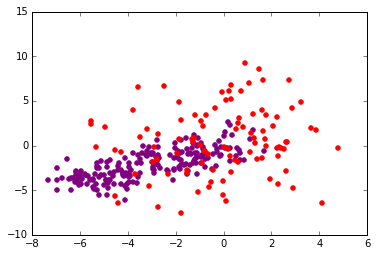

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(thinned_results[:,10], thinned_results[:,12], color="purple")
plt.scatter(true_theta[:,10], true_theta[:,12], color="red")

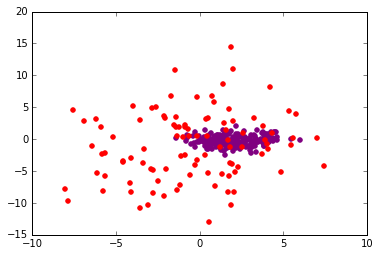

In [149]:
%matplotlib inline
plt.scatter(thinned_results[:,6], thinned_results[:,9], color="purple")
plt.scatter(true_theta[:,6], true_theta[:,9], color="red")

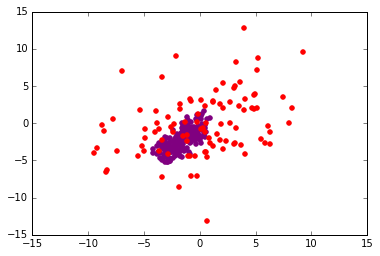

In [152]:
%matplotlib inline
plt.scatter(thinned_results[:,1], thinned_results[:,4], color="purple")
plt.scatter(true_theta[:,1], true_theta[:,4], color="red")

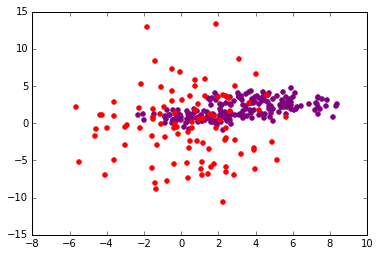

In [153]:
%matplotlib inline
plt.scatter(thinned_results[:,3], thinned_results[:,5], color="purple")
plt.scatter(true_theta[:,3], true_theta[:,5], color="red")